This is a notebook tutorial for usage of CRISMImageN2N4M to denoise CRISM imagery. If you are not familiar with the CRISMImage class, please complete that tutorial first as the data downloaded there is required here.

In [11]:
# Standard Imports
import matplotlib.pyplot as plt

# Imports from this project
from n2n4m.crism_image import CRISMImageN2N4M
from n2n4m.plot import DenoisedVisualiser, DenoisedInteractiveVisualiser
from n2n4m.model import Noise2Noise1D
from n2n4m.wavelengths import ALL_WAVELENGTHS
import torch

In [2]:
# Instantiate the CRISMImageN2N4M object
IMAGE_PATH = "../data/example_image/ATU0003561F_01_IF168L_TRR3.img"
example_image = CRISMImageN2N4M(IMAGE_PATH)

Image loaded successfully.


CRISMImageN2N4M is inherited from CRISMImage thus the base useage is identical.

In [3]:
# Get a description of the image
print(
    f"Image Name: {example_image.im_name}\n"
    f"Spatial dimensions: {example_image.spatial_dims}\n"
    f"Number of bands: {example_image.num_bands}\n"
)

Image Name: ATU0003561F
Spatial dimensions: (151, 640)
Number of bands: 438



In [4]:
CRISM_ML_DATA_DIR = "../data/CRISM_ML/"
example_image.ratio_image(CRISM_ML_DATA_DIR)

/home/rob_platt/N2N4M/N2N4M/n2n4m/preprocessing.py:243: RuntimeWarning: Mean of empty slice
  image_copy = np.nan_to_num(image_copy, nan=np.nanmean(image_copy, axis=0))
/home/rob_platt/anaconda3/envs/test/lib/python3.11/site-packages/crism_ml/preprocessing.py:410: RuntimeWarning: invalid value encountered in divide
  normed = pixspec[idx, :, :] / bland


To use N2N4M denoising, first must instantiate a model, and a feature scaler.

In [5]:
# Can use the default scaler and model:
example_image.load_n2n4m_scaler()
example_image.load_n2n4m_model()

In [6]:
# Or can use our own:
model = Noise2Noise1D(kernel_size=5, depth=3, num_input_features=350, num_blocks=4) # Create a model
# Load the model weights from a file. In this case using the default trained weights, on CPU. GPU acceleration is supported
model_state_dict = torch.load("../n2n4m/data/trained_model_weights.pt", map_location=torch.device('cpu')) 
new_model_state_dict = {
        k.replace("module.", ""): v for k, v in model_state_dict.items()
    }  # Model was trained on multiple GPUs, so need to remove "module." from keys
model.load_state_dict(new_model_state_dict) # Load the weights into the model
model.eval() # Set the model to evaluation mode as we are not retraining it
example_image.load_n2n4m_model(model=model) # Load the model into the CRISMImageN2N4M object
# Load the scaler into the CRISMImageN2N4M object. In this case the default scaler - fit to the training data - is used.
example_image.load_n2n4m_scaler(filepath="../n2n4m/data/n2n4m_feature_scaler.joblib") 

In [7]:
# To denoise the image. This may take up to 10 minutes depending on the image size and the hardware used.
example_image.n2n4m_denoise(batch_size=1000) # If struggling with memory usage, reduce the batch size

/home/rob_platt/anaconda3/envs/test/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


In [9]:
# We can then ratio the denoised image
example_image.ratio_denoised_image(CRISM_ML_DATA_DIR)

/home/rob_platt/N2N4M/N2N4M/n2n4m/preprocessing.py:243: RuntimeWarning: Mean of empty slice
  image_copy = np.nan_to_num(image_copy, nan=np.nanmean(image_copy, axis=0))
/home/rob_platt/anaconda3/envs/test/lib/python3.11/site-packages/crism_ml/preprocessing.py:410: RuntimeWarning: invalid value encountered in divide
  normed = pixspec[idx, :, :] / bland


In [ ]:
# Can also calculate a summary parameter
example_image.calculate_summary_parameter("hyd_femg_clay_index")

In [10]:
# To plot, instantiate an object of the DenoisedVisualiser class
denoised_vis = DenoisedVisualiser(example_image)

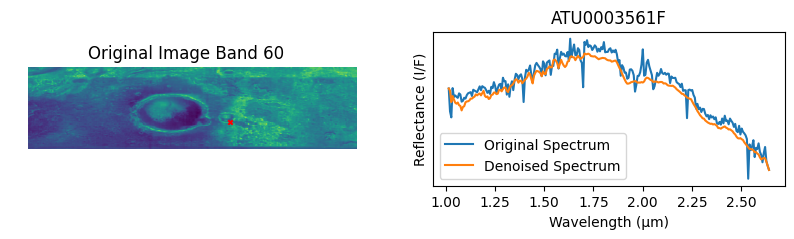

In [20]:
# We can then plot a comparison between the original spectra and the denoised data.
spectra_location = (400,100) # Change this to whichever spectra you would like to view
fig, ax = plt.subplots(1, 2, figsize=(10,2))

denoised_vis.plot_image(denoised_vis.get_image(60), title="Original Image Band 60", ax=ax[0]) # Plot the image
ax[0].scatter(*spectra_location, c="r", s=10, marker="x") # Add a cross for the spectra location

original_spectrum = denoised_vis.get_raw_spectrum(spectra_location) # Get an example original spectra
denoised_spectrum = denoised_vis.get_denoised_spectrum(spectra_location) # Get an example denoised spectra

# Lets only plot the first 250 bands, as these are of more interest
denoised_vis.plot_spectrum(original_spectrum[:250], bands=ALL_WAVELENGTHS[:250], ax=ax[1], title="Comparison between original and denoised spectra")
denoised_vis.plot_spectrum(denoised_spectrum[:250], bands=ALL_WAVELENGTHS[:250], ax=ax[1])

legend = ["Original Spectrum", "Denoised Spectrum"] # Add a legend
ax[1].legend(legend, loc="lower left")


In a Jupyter notebook, we can also create an interactive visualisation, to dynamically plot the image and spectra.  
X and Y sliders allow us to move around the image, and the spectra are plotted for the pixel at the current X and Y position.  
Image Band controls which band of the image to plot.  
Image Options displays any additional images that have been added to the visualiser, such as the summary parameters.  
Spectrum Bands controls the range of bands to plot, from 1-438. Imput as a range, e.g. 1-250.  
Spectrum Type controls whether you wish to plot the raw, or ratioed spectra.
The Original Spectrum and Denoised Spectrum control which spectra are plotted.

In [26]:
# Can also make an interactive version for use in Jupyter Notebooks
denoised_interactive_vis = DenoisedInteractiveVisualiser(example_image)
denoised_interactive_vis.interactive_plot()